In [26]:
import sys
sys.path.append('../ATLAS_anomaly_detection/.')
sys.path.append('../ATLAS_anomaly_detection/decorrelation/.')
from utils import load_LHCO
from helpers import add_vars
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [21]:
lhco = load_LHCO()
data, sim, signal = add_vars(lhco['pythia_qcd']), add_vars(lhco['herwig_qcd']), add_vars(lhco['wprime'])

In [600]:
from sklearn.model_selection import train_test_split

n_signal = 3000
cols = ['mJJ', 'maxmass', 'minmass', 'tau21a', 'tau21b']
x = np.concatenate([data.loc[:,cols].values, sim.loc[:,cols].values, signal.loc[:,cols].iloc[np.random.choice(len(signal), n_signal, replace=False)].values])
                    #signal.loc[:,cols].values])
x[:,:3]/=1000
y = np.concatenate([np.ones(len(data)), np.zeros(len(sim)), np.ones(n_signal)])#np.ones(len(signal))])
y_true = np.concatenate([np.zeros(len(data)), np.zeros(len(sim)), np.ones(n_signal)])#np.ones(len(signal))])

x_train, x_test, y_train, y_test, y_true_train, y_true_test = train_test_split(x, y, y_true, test_size=0.5)

x_tr, y_tr = x_train,y_train #x_train[~y_true_train.astype(bool)], y_train[~y_true_train.astype(bool)]
mjj = x_tr[:,0]



sb = ((mjj > 3.0) & (mjj < 3.3)) | ((mjj > 3.7) & (mjj < 4.0))
sr = ((mjj <= 3.7) & (mjj >= 3.3))

print(((y_true_train==1)&(y_train==1)&(sr==1)).sum()/np.sqrt(((y_true_train==0)&(y_train==1)&(sr==1)).sum()))

2.346551573461598


In [571]:

sb_model = keras.models.Sequential()
sb_model.add(keras.layers.Dense(64, input_shape=(5,), activation='relu'))
sb_model.add(keras.layers.Dense(64, activation='relu'))
sb_model.add(keras.layers.Dense(64, activation='relu'))
sb_model.add(keras.layers.Dense(1, activation='sigmoid'))

sr_model = keras.models.Sequential()
sr_model.add(keras.layers.Dense(64, input_shape=(4,), activation='relu'))
sr_model.add(keras.layers.Dense(64, activation='relu'))
sr_model.add(keras.layers.Dense(64, activation='relu'))
sr_model.add(keras.layers.Dense(1, activation='sigmoid'))

model = SALAD(
    sb_model=sb_model, sr_model=sr_model, m_cols=[0], 
    sr_epochs=10, sb_epochs=10, test_size=0, 
    sr_batch_size=200, sb_batch_size=200
)
s.fit(x_train[sb], y_train[sb], x_train[sr], y_train[sr])

(<tensorflow.python.keras.callbacks.History at 0x7f203dea1eb8>,
 <tensorflow.python.keras.callbacks.History at 0x7f203dbbd588>)

In [634]:
base_model = keras.models.Sequential()
base_model.add(keras.layers.Dense(64, input_shape=(5,), activation='relu'))
base_model.add(keras.layers.Dense(64, activation='relu'))
base_model.add(keras.layers.Dense(64, activation='relu'))
base_model.add(keras.layers.Dense(1, activation='sigmoid'))
base_model_arch = base_model.to_json()

In [646]:
%run models.py

dvsim = data_vs_sim(model=base_model_arch, verbose=1)
dvsim.fit(x_train[sr], y_train[sr], w=0.001*np.ones_like(y_train[sr]))

Train on 85475 samples, validate on 36633 samples
Epoch 1/10
85475/85475 [==============================] - 11s 129us/step - loss: 0.6879 - val_loss: 0.6845
Epoch 2/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6841 - val_loss: 0.6875
Epoch 3/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6842 - val_loss: 0.6833
Epoch 4/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6835 - val_loss: 0.6837
Epoch 5/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6833 - val_loss: 0.6849
Epoch 6/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6836 - val_loss: 0.6828
Epoch 7/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6831 - val_loss: 0.6841
Epoch 8/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6833 - val_loss: 0.6827
Epoch 9/10
85475/85475 [==============================] - 1s 7us/step - loss: 0.6827 - val_loss: 0.6833
Epoch 10/10

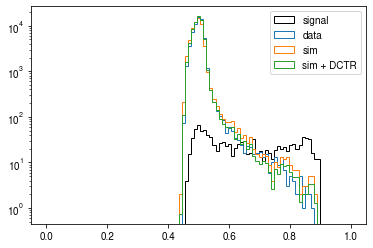

In [573]:
def plot_set(x, y, w):
    for i in range(x.shape[1]):
        plt.figure()
        _,bins,_ = plt.hist(x[y==1,i], histtype='step', bins=100, weights=None, label='data')
        plt.hist(x[y==0,i], histtype='step', bins=bins, weights=None, label='sim')
        plt.hist(x[y==0,i], histtype='step', bins=bins, weights=w[y==0], label='sim + DCTR')
        plt.legend()
        plt.show()
        
yhat = np.squeeze(s.predict(x_train[sr]))
w_sr = s.predict_weight(x_train[sr])

plt.hist(yhat[(y_train[sr] == 1) & (y_true_train[sr] == 1)], histtype='step', bins=np.linspace(0,1,100), label='signal', color='black')
plt.hist(yhat[(y_train[sr] == 1) & (y_true_train[sr] == 0)], histtype='step', bins=np.linspace(0,1,100), label='data')
plt.hist(yhat[y_train[sr] == 0], histtype='step', bins=np.linspace(0,1,100), label='sim')
plt.hist(yhat[y_train[sr] == 0], histtype='step', weights=w_sr[y_train[sr] == 0], bins=np.linspace(0,1,100), label='sim + DCTR')
plt.legend()
plt.yscale('log')
plt.show()

In [575]:
yhat_test_sr = s.predict(x_test[(x_test[:,0] < 3.7) & (x_test[:,0] > 3.3)])
y_true_test_sr = y_true_test[(x_test[:,0] < 3.7) & (x_test[:,0] > 3.3)]


In [658]:
%run models.py

In [659]:
dvsim = data_vs_sim(model=dvsim.model)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


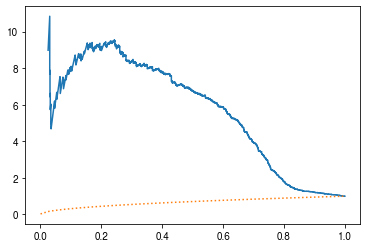

In [576]:
from sklearn.metrics import roc_curve

fpr,tpr,thresh = roc_curve(y_true_test_sr, yhat_test_sr)
plt.plot(tpr, tpr/np.sqrt(fpr))
plt.plot(tpr, tpr/np.sqrt(tpr), ls=':')

In [602]:
window = (x_test[:,0] < 4.5) & (x_test[:,0] > 2.5)
dtag = y_test[window] == 1
stag = y_test[window] == 0


In [660]:
%timeit dvsim.predict(x_test[window])

247 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [662]:
snew = SALAD()

In [666]:
pms = s.get_params()
del pms['path']

In [668]:
snew.sr_model

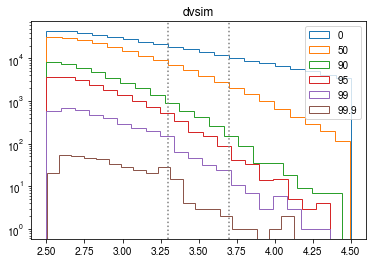

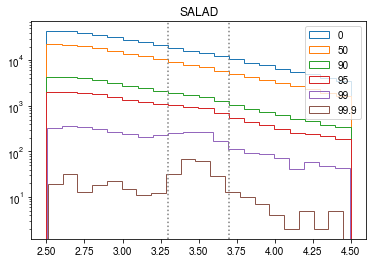

In [669]:

pvals = [0, 50, 90, 95, 99, 99.9]

for model_name,m in {'dvsim': dvsim, 'SALAD': s}.items():
    yhat_all = m.predict(x_test[window])

    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct

        plt.hist(x_test[window,0][dtag][tag], histtype='step', label=p, density=0, bins=20)

    plt.gca().axvline(3.3, color='tab:grey', ls=':')
    plt.gca().axvline(3.7, color='tab:grey', ls=':')

    plt.title('{}'.format(model_name))
    plt.legend()
    plt.yscale('log')
    plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract


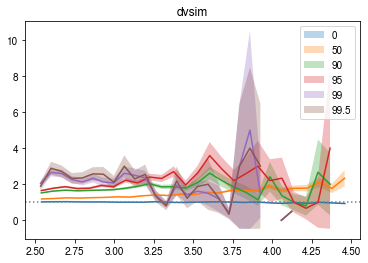

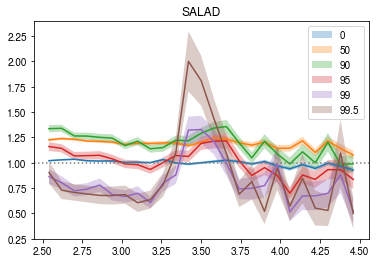

In [670]:
pvals = [0, 50, 90, 95, 99, 99.5]

for model_name,m in {'dvsim': dvsim, 'SALAD': s}.items():
    yhat_all = m.predict(x_test[window])
    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct
        tag_s = yhat_all[stag] >= pct


        dcnts,bns = np.histogram(x_test[window,0][dtag][tag], bins=25,)
        scnts,bns = np.histogram(x_test[window,0][stag][tag_s], bins=25,)
        xpt = bns[:-1] + np.diff(bns)*.5

        val = (dcnts/scnts)
        err = val*np.sqrt(1/dcnts + 1/scnts)

        plt.plot(xpt, val)
        plt.fill_between(xpt, val - err, val + err, alpha=.3, label=p)

    plt.legend()
    plt.axhline(1, color='tab:grey', ls=':')
    plt.title(model_name)
    plt.show()

In [ ]:
w_sb = s.predict_weight(x_tr[sb])
plot_set(x_tr[sb], y_tr[sb], w_sb)

In [ ]:
w_sr = s.predict_weight(x_tr[sr])
plot_set(x_tr[sr], y_tr[sr], w_sr)